# ANAC


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

#### Seed

In [2]:
seed = 2024
np.random.seed(seed)

In [3]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12620\3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [6]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
df

,AuthorId,RecipeId,Rating,Like,TestSetId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,...,RecipeServings,RecipeYield,Diet,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2492191A,33671,2.0,NaN,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,One dish meal,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...",...,4.0,NaN,Omnivore,19,2698.714376,0.0,Indifferent,1,0,1
1,2002019979A,92647,2.0,NaN,2.0,Pork and Chickpea Chili,1200,1200,Other,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...",...,6.0,NaN,Omnivore,66,2399.694583,1.0,Indifferent,0,Indifferent,1
2,408594E,161770,NaN,NaN,3.0,Stuffed Zucchini With Sausage,1200,900,Other,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...",...,4.0,NaN,Omnivore,35,2099.113170,1.0,Indifferent,0,0,1
3,2001625557E,108231,2.0,NaN,4.0,Cream Cheese and Beef Cracker Spread,0,1200,Other,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")",...,NaN,2 cups,Omnivore,76,1199.645575,1.0,Yes,0,0,1
4,2001427116E,71109,NaN,NaN,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,Other,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...",...,4.0,4 Breast halves,Omnivore,56,2341.181827,1.0,Indifferent,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,2.0,False,NaN,Pumpkin Cake Mix Dessert,3000,900,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...",...,16.0,NaN,Vegetarian,31,3899.421310,0.0,Indifferent,1,Indifferent,0
140191,999774A,29002,2.0,False,NaN,Summer Corkscrew Pasta,1200,1200,Other,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...",...,4.0,NaN,Vegetarian,57,2402.372535,0.0,Indifferent,0,Indifferent,0
140192,999774A,159252,NaN,False,NaN,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,Other,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")",...,NaN,4 cups,Vegetarian,57,5999.598903,0.0,Yes,0,0,0
140193,999774A,1171,2.0,True,NaN,Kahlua Hot Chocolate,360,120,Beverages,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...",...,1.0,2 mugs,Vegetarian,57,480.233207,1.0,Yes,0,0,0


***Split Data***

In [25]:
# Split data into train and test set

train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

test_set

,AuthorId,RecipeId,Rating,Like,TestSetId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,...,RecipeServings,RecipeYield,Diet,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2492191A,33671,2.0,NaN,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,One dish meal,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...",...,4.0,NaN,Omnivore,19,2698.714376,0.0,Indifferent,1,0,1
1,2002019979A,92647,2.0,NaN,2.0,Pork and Chickpea Chili,1200,1200,Other,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...",...,6.0,NaN,Omnivore,66,2399.694583,1.0,Indifferent,0,Indifferent,1
2,408594E,161770,NaN,NaN,3.0,Stuffed Zucchini With Sausage,1200,900,Other,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...",...,4.0,NaN,Omnivore,35,2099.113170,1.0,Indifferent,0,0,1
3,2001625557E,108231,2.0,NaN,4.0,Cream Cheese and Beef Cracker Spread,0,1200,Other,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")",...,NaN,2 cups,Omnivore,76,1199.645575,1.0,Yes,0,0,1
4,2001427116E,71109,NaN,NaN,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,Other,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...",...,4.0,4 Breast halves,Omnivore,56,2341.181827,1.0,Indifferent,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2000357827D,194823,NaN,NaN,42810.0,Philadelphia Caramel-Pecan Cheesecake,2700,900,Other,"c(""\""1 1/2\"""", ""\""1\"""", ""\""1/4\"""", ""\""4\"""", ""\...",...,20.0,NaN,Vegetarian,31,3600.286373,0.0,Yes,1,0,0
42810,2000357827D,35775,NaN,NaN,42811.0,Sweet Dreams Crunch Cherry Dump Cake,3600,300,Other,"c(""\""1\"""", ""\""1\"""", ""\""1/2\"""")",...,12.0,NaN,Vegetarian,31,3900.022844,1.0,Indifferent,1,Indifferent,1
42811,2915363A,26820,2.0,NaN,42812.0,Appetizers-Easy Stuffed Mushrooms,420,2100,Other,"c(""\""8\"""", ""\""3\"""", ""\""1/4\"""", ""\""1/4\"""", ""\""1...",...,6.0,NaN,Vegetarian,35,2518.748251,0.0,Indifferent,1,0,0
42812,2001538344B,512974,2.0,NaN,42813.0,"Wild Rice, Brown Rice and Dried Fruit Pilaf",2400,1800,Other,"c(""\""3/4\"""", ""\""3/4\"""", ""\""4\"""", ""\""1/2\"""", ""\...",...,8.0,NaN,Vegetarian,61,4199.867547,0.0,Yes,0,0,0


### Data Cleaning

#### Basics

In [26]:
# Rename AuthorId column
train_set.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

# Change types of Diet & RecipeCategory into category
train_set["Diet"] = train_set["Diet"].astype("category")
train_set["RecipeCategory"] = train_set["RecipeCategory"].astype("category")

# Change types to boolean
train_set["HighCalories"] = train_set["HighCalories"].astype("bool")
train_set["LowFat"] = train_set["LowFat"].astype("bool")
train_set["HighFiber"] = train_set["HighFiber"].astype("bool")
train_set["Like"] = train_set["Like"].astype("boolean")

# Remove NA rows and Rating column and TestSetId
train_set = train_set.drop("Rating", axis=1)
train_set = train_set.drop("TestSetId", axis=1)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12620\2225015653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12620\2225015653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["Diet"] = train_set["Diet"].astype("category")
C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_12620\2225015653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Missing values

In [48]:
train_set['Diet'].fillna('Vegetarian', inplace=True)
# diet_csv = diet_csv.dropna(axis="rows")

train_set.dropna(subset=["Like"], inplace=True)

# Map indifferent values for HighProtein and LowSugar
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
train_set["HighProtein"] = train_set["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
train_set["LowSugar"] = train_set["LowSugar"].map(mapping_sugar).astype('category')

# One hot encoding for categorical variables
train_set = pd.get_dummies(train_set, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)

In [50]:
maxtime_val = train_set['Time'].max()
outliers = train_set['Time'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'Time'].median()
train_set.loc[outliers, 'Time'] = median_without_outliers

maxtime_val = train_set['PrepTime'].max()
outliers = train_set['PrepTime'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'PrepTime'].median()
train_set.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['PrepTime'] > 3000000)
train_set.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['Calories'] > 30000)
median_without_outliers = train_set.loc[~outliers, 'Calories'].median()
train_set.loc[outliers, 'Calories'] = median_without_outliers

outliers = train_set['FatContent'] > 25000
median_without_outliers = train_set.loc[~outliers, 'FatContent'].median()
train_set.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['FatContent'] > 2500)
train_set.loc[outliers, 'FatContent'] = median_without_outliers

outliers = train_set['SaturatedFatContent'] > 12000
median_without_outliers = train_set.loc[~outliers, 'SaturatedFatContent'].median()
train_set.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = train_set['CholesterolContent'] > 35000
median_without_outliers = train_set.loc[~outliers, 'CholesterolContent'].median()
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['CholesterolContent'] > 10000)
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['CarbohydrateContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'CarbohydrateContent'].median()
train_set.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['FiberContent'] > 400)
median_without_outliers = train_set.loc[~outliers, 'FiberContent'].median()
train_set.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['SugarContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'SugarContent'].median()
train_set.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = train_set['ProteinContent'] > 17500
median_without_outliers = train_set.loc[~outliers, 'ProteinContent'].median()
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['ProteinContent'] > 3000)
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = train_set['RecipeServings'] > 30000
median_without_outliers = train_set.loc[~outliers, 'RecipeServings'].median()
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['RecipeServings'] > 400)
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers

In [51]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)

In [52]:
# Add additional varibale for difference in requested time and recipe time
train_set["DifferenceRequestedAndTimeNeeded"] = train_set["Time"] - (train_set["CookTime"] + train_set["PrepTime"])

***Train Model***


In [53]:
X = train_set.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'RecipeServings'], axis=1)
y = train_set['Like']

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saled_df = scaler.fit_transform(X)
saled_df

array([[0.00000000e+00, 2.31481481e-05, 3.95750772e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.05625311e-03],
       [5.78703704e-05, 1.15740741e-04, 1.12904528e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05632278e-03],
       [5.78703704e-06, 5.78703704e-05, 3.58372725e-04, ...,
        1.00000000e+00, 0.00000000e+00, 2.05685526e-03],
       ...,
       [4.62962963e-04, 2.31481481e-04, 2.64784944e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05636362e-03],
       [3.47222222e-05, 2.31481481e-05, 1.90000317e-03, ...,
        1.00000000e+00, 1.00000000e+00, 2.05648575e-03],
       [2.60416667e-04, 1.73611111e-04, 5.55820119e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.05651551e-03]])

In [55]:
transform_scaler = StandardScaler()

scaled_df = transform_scaler.fit_transform(saled_df)
scaled_df

array([[-0.04894697, -0.06219095, -0.25682605, ..., -0.81338387,
        -1.52559654, -0.00574877],
       [-0.04369982, -0.04994256, -0.06601104, ...,  1.2294318 ,
         0.6554813 , -0.00573365],
       [-0.04842226, -0.0575978 , -0.26655242, ...,  1.2294318 ,
        -1.52559654, -0.00561809],
       ...,
       [-0.00696979, -0.03463208,  0.32920619, ...,  1.2294318 ,
         0.6554813 , -0.00572479],
       [-0.04579868, -0.06219095,  0.13460458, ...,  1.2294318 ,
         0.6554813 , -0.00569828],
       [-0.0253348 , -0.04228732, -0.21517344, ..., -0.81338387,
        -1.52559654, -0.00569182]])

In [56]:
X_train, X_test, y_train, y_test = \
    train_test_split(scaled_df, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

In [168]:
train_model = RandomForestClassifier(n_estimators=100, random_state=seed)

train_model.fit(X_train,y_train)

# Calculate balanced accuracy
pred = train_model.predict(X_test)
score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

KeyboardInterrupt: 

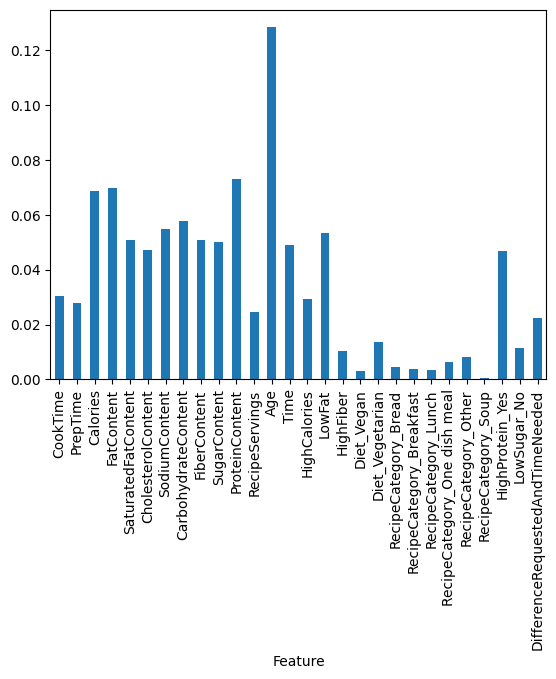

In [130]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [131]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
20653  False             0.0                0.99                0.01
82063  False             0.0                0.88                0.12
85333  False             0.0                0.95                0.05
96197  False             0.0                0.97                0.03
83016  False             0.0                0.83                0.17
...      ...             ...                 ...                 ...
47865  False             0.0                0.93                0.07
22491   True             0.0                0.90                0.10
10052  False             0.0                1.00                0.00
44580  False             0.0                0.89                0.11
4127   False             0.0                0.96                0.04

[29215 rows x 4 columns]
Confusion Matrix:
[[24797   580]
 [ 2414  1424]]
Test-Precision: 0.7105788423153693
Test-Accuracy: 0.8975183980831765
Test-Recall: 0.3710265763418

***TestSet***

In [57]:
# Gradient Boosting

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.6, random_state=seed)

train_model.fit(X_train,y_train)

score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.6996236508970365


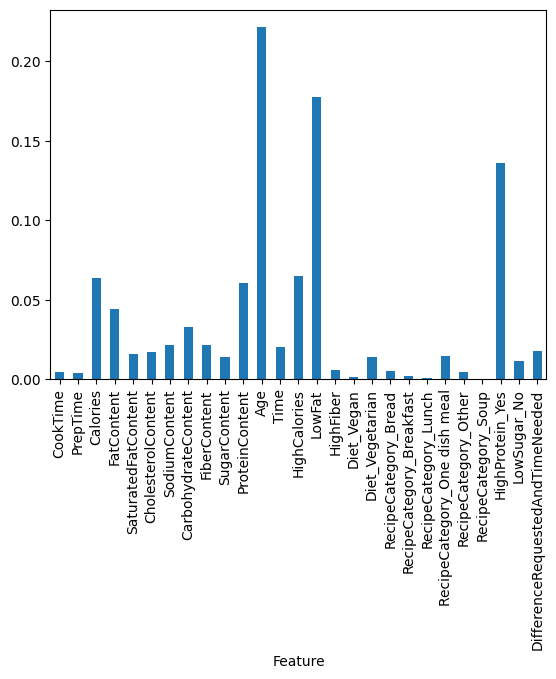

In [58]:
# Plot feature importance 
importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

In [59]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
20653  False             0.0            0.976464            0.023536
82063  False             0.0            0.946770            0.053230
85333  False             0.0            0.996183            0.003817
96197  False             0.0            0.946661            0.053339
83016  False             0.0            0.586847            0.413153
...      ...             ...                 ...                 ...
47865  False             0.0            0.940602            0.059398
22491   True             0.0            0.766861            0.233139
10052  False             0.0            0.991813            0.008187
44580  False             0.0            0.723345            0.276655
4127   False             0.0            0.994901            0.005099

[29215 rows x 4 columns]
Confusion Matrix:
[[24481   896]
 [ 2091  1747]]
Test-Precision: 0.6609912977676883
Test-Accuracy: 0.8977580010268698
Test-Recall: 0.4551849921834


#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data

***Output file with test set***

In [95]:
diet_csv = pd.read_csv('diet.csv')
reviews_csv = pd.read_csv('reviews.csv')
requests_csv = pd.read_csv('requests.csv')
recipes_csv = pd.read_csv('recipes.csv')
testset = pd.read_csv("pub_YwCznU3.csv")

df_merge_1 = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
df_merge_2 = pd.merge(df_merge_1, recipes_csv, how="inner", on="RecipeId")
df_merge_3 = pd.merge(df_merge_2, reviews_csv, how="inner", on=["AuthorId", "RecipeId"])

df_merge_3.rename(columns= {"TestSetId" : "id"}, inplace=True)

df_test = pd.merge(df_merge_3, testset, how="inner", on="id")
df_test["id"].astype("int")
df_test["Diet"].astype("category")
df_test["RecipeCategory"].astype("category")
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
df_test["HighProtein"] = df_test["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
df_test["LowSugar"] = df_test["LowSugar"].map(mapping_sugar).astype('category')

df_test["DifferenceRequestedAndTimeNeeded"] = df_test["Time"] - (df_test["CookTime"] + df_test["PrepTime"])

df_test = df_test.drop(['AuthorId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield',"id","prediction", "Rating", "RecipeServings"], axis=1)
df_test = pd.get_dummies(df_test, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)
df_test = df_test.reindex(columns=["CookTime", "PrepTime", "Calories", "FatContent", "SaturatedFatContent", "CholesterolContent", 'SodiumContent', "CarbohydrateContent", "FiberContent", "SugarContent", "ProteinContent", "Age","Time","HighCalories","LowFat","HighFiber","Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_One dish meal", "RecipeCategory_Other", "RecipeCategory_Soup", "HighProtein_Yes", "LowSugar_No", 'DifferenceRequestedAndTimeNeeded'])

predictions = pd.DataFrame(columns=["prediction"])
predictions["prediction"] = train_model.predict(df_test).astype("int")

output = pd.DataFrame(predictions)
output['id'] = df_test.index
output = output.reindex(columns=["id", "prediction"])
output.id += 1
output.to_csv("predictions_LetsSeePaulAllens'BAC_1.csv", index=False)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_11108\1202071335.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv('reviews.csv')
c:\users\maximilian mittmann\pycharmprojects\analyticscuptumforrest\venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,id,prediction
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
42809,42810,1
42810,42811,1
42811,42812,1
42812,42813,1
